In [4]:
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
import earthaccess
import joblib
import json
import pandas as pd
import numpy as np
from shapely.geometry import shape
import xarray as xr
from typing import Dict, Any
import fsspec
from pystac_client import Client

import data_classes


In [10]:
# Load model
model = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')

In [3]:
with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)

In [4]:
crystal_mountain_area = [site for site in ski_areas['features'] if site['properties']['name'] == 'Crystal Mountain'][0]
# crystal_mountain_area

In [5]:
# Alternative: Get bounds directly from shapely geometry
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_bounds = crystal_polygon.bounds  # Returns (minx, miny, maxx, maxy)

print(f"\nDirect bounds: {crystal_bounds}")


Direct bounds: (-121.5089145, 46.90889530000001, -121.46718410000003, 46.9567407)


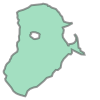

In [6]:
crystal_polygon

In [7]:
stac_api = "https://landsatlook.usgs.gov/stac-server"
collections =  ["landsat-c2ard-sr"] # "landsat-c2l3-fsca" will also be used for snow cover fraction
fs = fsspec.filesystem("s3", anon=False, requester_pays=True)
start_date, end_date = '1982-01-01', '2024-12-31'

In [8]:
client = Client.open(stac_api)
landsat_item_search = client.search(
    collections=collections,
    bbox=crystal_bounds,
    datetime=(start_date, end_date)
)

landsat_item_search.matched()

2534

In [9]:
landsat_items = landsat_item_search.item_collection()

In [10]:
def process_item_parallel(args: tuple) -> Dict[str, Any]:
    """Process a single item in parallel"""
    fs, item, polygon = args
    extractor = data_classes.HLSDataExtractor(fs=fs, item=item)
    manager = data_classes.SatelliteDataManager(
        extractor=extractor
    )    
    return manager.extract_inference_data(polygon)

In [20]:
# %%time
# # for testing
# result = process_item_parallel((fs, landsat_items[2], crystal_polygon))

In [14]:
batch_size = 10
start_idx = 0
end_idx = len(landsat_items)
max_workers = 10

results = []
for i in range(start_idx, end_idx, batch_size):
    args_list = [(fs, item, crystal_polygon) for item in landsat_items[i:i+batch_size]]
    print(f"Processing items {i} to {i+batch_size} of {len(landsat_items)}")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_item = {
            executor.submit(process_item_parallel, args): args[1] 
            for args in args_list
        }
        
        # Process completed tasks
        for future in as_completed(future_to_item):
            item = future_to_item[future]
            try:
                result = future.result()
                if result is not None:
                    results.append(result)
            except Exception as e:
                print(f"Error processing item {item.id}: {e}")
    gc.collect()

Processing items 0 to 10 of 2534
Processing items 10 to 20 of 2534
Processing items 20 to 30 of 2534
Processing items 30 to 40 of 2534
Processing items 40 to 50 of 2534
Processing items 50 to 60 of 2534
Processing items 60 to 70 of 2534
Processing items 70 to 80 of 2534
Processing items 80 to 90 of 2534
Processing items 90 to 100 of 2534
Processing items 100 to 110 of 2534
Processing items 110 to 120 of 2534
Processing items 120 to 130 of 2534
Processing items 130 to 140 of 2534
Processing items 140 to 150 of 2534
Processing items 150 to 160 of 2534
Processing items 160 to 170 of 2534
Processing items 170 to 180 of 2534
Processing items 180 to 190 of 2534
Processing items 190 to 200 of 2534
Processing items 200 to 210 of 2534
Processing items 210 to 220 of 2534
Processing items 220 to 230 of 2534
Processing items 230 to 240 of 2534
Processing items 240 to 250 of 2534
Processing items 250 to 260 of 2534
Processing items 260 to 270 of 2534
Processing items 270 to 280 of 2534
Processing i

In [24]:
results_df = pd.concat(results)

In [25]:
results_df.shape

(20135507, 11)

In [26]:
#results_df.to_parquet('results.parquet')

In [5]:
# Load data
results_df = pd.read_parquet('results.parquet')
results_df = results_df.dropna(subset=['fsca'])

In [6]:
results_df['datetime'] = pd.to_datetime(results_df['time'])
results_df['day'] = results_df['datetime'].dt.day
results_df['month'] = results_df['datetime'].dt.month
results_df['year'] = results_df['datetime'].dt.year
results_df.loc[~results_df['fsca'].between(0, 1000), 'fsca'] = None

In [7]:
results_df.head()

,time,longitude,latitude,coastal,blue,green,red,nir08,swir16,swir22,fsca,datetime,day,month,year
0,2024-12-25T18:49:51.253821Z,-121.508679,46.922242,36261.0,35869,34486,34155,33048,17509,18436,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
1,2024-12-25T18:49:51.253821Z,-121.508679,46.921895,36219.0,35757,34552,34083,32874,17493,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
2,2024-12-25T18:49:51.253821Z,-121.508679,46.921547,36237.0,35765,34417,34086,32936,17457,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
3,2024-12-25T18:49:51.253821Z,-121.508679,46.921199,36219.0,35760,34536,34043,32889,17450,18471,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
4,2024-12-25T18:49:51.253821Z,-121.508331,46.923286,36363.0,35863,34542,34192,33038,17589,18608,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024


In [11]:

input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca", "latitude", "longitude", "month"]
x_input_data = results_df[input_columns]
x_scaled = X_scaler.transform(x_input_data)


In [12]:
y_pred = model.predict(x_scaled)
y_pred

array([0.28870968, 0.29087558, 0.2924424 , ..., 0.08354839, 0.08737327,
       0.08737327], shape=(19957490,))

In [13]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
y_scaled

array([[62.65000015],
       [63.12000019],
       [63.46000013],
       ...,
       [18.1300001 ],
       [18.9600001 ],
       [18.9600001 ]], shape=(19957490, 1))

In [14]:
results_df['snow_depth_prediction'] = y_scaled

In [15]:
results_df.shape

(19957490, 16)

In [30]:
# get average snow depth over the resort area from all pixels available for a given month-year
results_grouped = results_df.groupby(['year', 'month']).agg({'snow_depth_prediction': 'mean'})

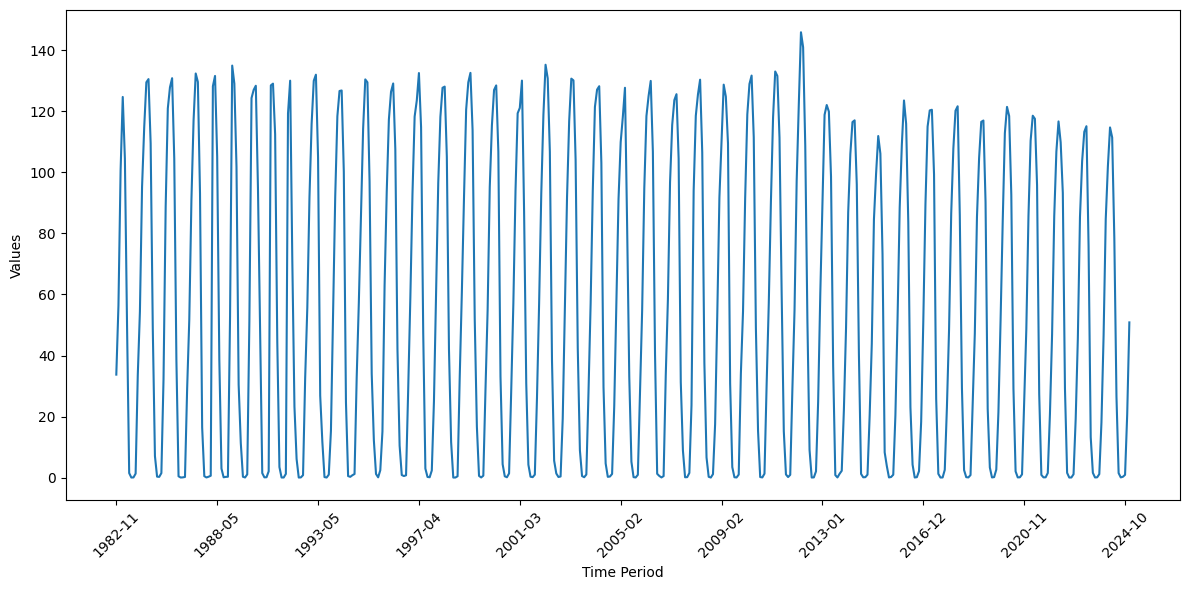

In [31]:
import matplotlib.pyplot as plt

# Sort by year and month first
df = results_grouped.reset_index()
df = df.sort_values(['year', 'month'])

# Create a combined month-year label
df['month_year'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(df)), df['snow_depth_prediction'])
plt.xlabel('Time Period')
plt.ylabel('Values')
plt.xticks(range(0, len(df), max(1, len(df)//10)), 
           df['month_year'].iloc[::max(1, len(df)//10)], 
           rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# what we have a matrix of observations, identified by datetime and a snow depth prediction for each pixel.
# We can multiply those by the size of each pixel to get the area of snow.
# Then we can sum those up to get the total area of snow for each year.
area_of_each_pixel = 30 * 30
reduced_pixels_df['snow_volume_prediction'] = reduced_pixels_df['snow_depth_prediction'] * area_of_each_pixel
reduced_pixels_df['snow_volume_prediction']

0       51290.999885
1       51974.999732
2       57762.000168
3       52253.999831
4       57474.000139
            ...     
8645    65538.000248
8646    65556.000281
8647    65340.000237
8648    66456.000258
8649    65556.000281
Name: snow_volume_prediction, Length: 8650, dtype: float64